# Blind Dating Analysis

File to process and analyze the data from the Blind Dating event.

The main goal is to determine which questions where useful in predicting a good date
based on a number of different outcomes.

Although "dating" might be the ideal outcome, seeing if people found compatability or
a new friend through the process should also be considered a success as the questions
largely asked about personality compatability.

Any findings should be considered in determining which questions to change, add, and remove.

In [252]:
# Importing neccesary packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, precision_score, f1_score, recall_score, classification_report, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

In [253]:
# Importing the datasets

dfPre = pd.read_csv("response.csv", header=None)
dfPost = pd.read_csv("postResponse.csv", header=None)
dfPreference = pd.read_csv("PreferenceList.csv", header=None)

Due to poor planning in the early part of this project, an unideal approach needed to be made regarding receiving questions in the code. Direct indexing is used. The reason the response.csv file has so many blank spaces that aren't just cleared is because it would mess up the indexing process. After this step, everything else follows more naturally.

This block with "qNames" lists all the info regarding what each question is in a shortened form to be referenced in visuals.

# Question Data and Indexing

Lists all of the question in two dictionaries:
qNames: each question label and what it represents
qData: each question label and what indices it calls, and a polarity number

In [254]:
# Creating dictionaries to map question numbers to their names
# Responses are formatted as Self vs. Want
# Negative signs (i.e. -58) do not mean a negative index, but rather a polarity flip
qNames = {
    # Emotion
    "Q1": "Cries often VS. Uncofmortable consoling the unwell", # Indices 59 VS. -58
    "Q2": "Tend to be anxious VS. Values self esteem in someone", # Indices 62 VS. -64
    "Q3": "Clearly articulate feelings VS. Clearly articulate feelings", # Indices 50 VS. 50
    "Q4": "Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts", # Indices 49 VS. 49
    "Q5": "Not embarrassed by others VS. Not embarrassed by others", # Indices 53 VS. 53
    # Conflict
    "Q6": "Shut down when yelled at VS. Heated easily", # Indices 54 VS. -55
    "Q7": "Seek to resolve conflict VS. Sweep issues under the rug", # Indices 56 VS. -57
    "Q8": "Having fun more important than winning VS. Having fun more important than winning", # Indices 60 VS. 60
    "Q9": "Persuaded more by something emotionally VS. Pursuaded more by something emotionally", # Indices 65 VS. 65
    "Q10": "Easy to say sorry VS. Easy to say sorry", # Indices 63 VS. 63
    # Extraversion
    "Q11": "Talk to strangers VS. Likes outgoing people", # Indices 32 VS. 33
    "Q12": "Is center of attention VS. Likes quieter personality", # Indices 36 VS. -39
    "Q13": "Burdened by initiating convrersation VS. Tends to initiate", # Indices 37 VS. 38
    "Q14": "Prefers to be by themselves VS. Prefers to be by themselves", # Indices 40 VS. 40
    "Q15": "Drained at big parties VS. Drained at big parties", # Indices 41 VS. 41
    "Q16": "Uncomfortable in noisy place VS. Uncomfortable in noisy place", # Indices 42 VS. 42
    # Lifestyle
    "Q17": "Seek out new experiences VS. Seek out new experiences", # Indices 34 VS. 34
    "Q18": "Love to be in nature VS. Love to be in nature", # Indices 35 VS. 35
    "Q19": "Bedroom is clean and tidy VS. Messy space is aggravating", # Indices 46 VS. -45
    "Q20": "Enjoys a structured schedule VS. Enjoys a structured schedule", # Indices 47 VS. 47
    "Q21": "Adjusts qick to last minute changes VS. Adjusts qick to last minute changes", # Indices 48 VS. 48
    "Q22": "Enjoy serving others VS. Enjoy serving others", # Indices 75 VS. 75
    "Q23": "Bothered if personally not on time or early VS. Often late", # Indices 74 VS. -88
    "Q24": "Worry about the future VS. Worry about the future", # Indices 44 VS. 44
    "Q25": "Social life over work VS. Social life over work", # Indices 43 VS. 43
    # Communication
    "Q26": "Reserved with emotions VS. Reserved with emotions", # Indices 51 VS. 51
    "Q27": "Speak without thinking VS. Speak without thinking", # Indices 52 VS. 52
    "Q28": "Okay lying to spare feelings VS. Okay lying to spare feelings", # Indices 61 VS. 61
    "Q29": "Great value in gift-giving VS. Not much value in receiving gifts", # Indices 76 VS. -77
    "Q30": "Texting over calls VS. Texting over calls", # Indices 72 VS. 72
    "Q31": "Express verbal appreciation to partner VS. Important to be complimented", # Indices 78 VS. 79
    # Partner Interaction
    "Q32": "Want to act like a couple in public VS. Want to act like a couple in public", # Indices 66 VS. 66
    "Q33": "Tend to be very affectionate VS. Tend to be very affectionate", # Indices 67 VS. 67
    "Q34": "Importance on small physical gestures VS. Importance on small physical gestures", # Indices 68 VS. 68
    "Q35": "Desire a partner who is playful VS. Desire a partner who is playful", # Indices 69 VS. 69
    "Q36": "Don't like getting physical quick VS. Don't like getting physical quick", # Indices 70 VS. 70
    "Q37": "Partner time more important than friend time VS. Partner time more important than friend time", # Indices 73 VS. 73
    # Partner Interaction
    "Q38": "Slapstick [Humor]", # Indices 104 VS. 104
    "Q39": "Sarcasm [Humor]", # Indices 105 VS. 105
    "Q40": "Dark Humor [Humor]", # Indices 106 VS. 106
    "Q41": "Self-Deprecating [Humor]", # Indices 107 VS. 107
    "Q42": "Wordplay/Puns [Humor]", # Indices 108 VS. 108
    "Q43": "Satire [Humor]", # Indices 109 VS. 109
    "Q44": "Deadpan [Humor]", # Indices 110 VS. 110
    "Q45": "Observational Humor [Humor]", # Indices 111 VS. 111
    "Q46": "Absurdist/Nonsensical [Humor]", # Indices 112 VS. 112
    "Q47": "Parody [Humor]", # Indices 113 VS. 113
    "Q48": "Impressions [Humor]", # Indices 114 VS. 114
    "Q49": "Bits [Humor]", # Indices 115 VS. 115
    "Q50": "Witty Banter [Humor]", # Indices 116 VS. 116
    "Q51": "BOTTOM TEXT [Humor]", # Indices 117 VS. 117
    "Q52": "*nuzzles you* [Humor]", # Indices 118 VS. 118
    "Q53": "Brain Rot [Humor]", # Indices 119 VS. 119
    "Q54": "How many booms do you give this survey [Question]", # Indices 120 VS. 120
    "Q55": "Does LOUD equal funny? [Humor]", # Indices 121 VS. 121
    "Q56": "Very long jokes with bad punchlines [Humor]", # Indices 122 VS. 122
    "Q57": "Dad Jokes [Humor]", # Indices 123 VS. 123
    "Q58": "Sexual Innuendo [Humor]", # Indices 124 VS. 124
    "Q59": "Situational Comedy [Humor]", # Indices 125 VS. 125
    "Q60": "Meta Humor [Humor]", # Indices 126 VS. 126
}

This block with "qData" specifies the indicies and polarity explained in the above block. This is used in the creation of the output file.

In [255]:
# Dictionary containing the index for each vector
# [Responder, Date, Polarity]
qData = {
    'Q1': [59, 58, -1],
    'Q2': [62, 64, -1],
    'Q3': [50, 50, 1],
    'Q4': [49, 49, 1],
    'Q5': [53, 53, 1],
    'Q6': [54, 55, -1],
    'Q7': [56, 57, -1],
    'Q8': [60, 60, 1],
    'Q9': [65, 65, 1],
    'Q10': [63, 63, 1],
    'Q11': [32, 33, 1],
    'Q12': [36, 39, -1],
    'Q13': [37, 38, 1],
    'Q14': [40, 40, 1],
    'Q15': [41, 41, 1],
    'Q16': [42, 42, 1],
    'Q17': [34, 34, 1],
    'Q18': [35, 35, 1],
    'Q19': [46, 45, -1],
    'Q20': [47, 47, 1],
    'Q21': [48, 48, 1],
    'Q22': [75, 75, 1],
    'Q23': [74, 88, -1],
    'Q24': [44, 44, 1],
    'Q25': [43, 43, 1],
    'Q26': [51, 51, 1],
    'Q27': [52, 52, 1],
    'Q28': [61, 61, 1],
    'Q29': [76, 77, -1],
    'Q30': [72, 72, 1],
    'Q31': [78, 79, 1],
    'Q32': [66, 66, 1],
    'Q33': [67, 67, 1],
    'Q34': [68, 68, 1],
    'Q35': [69, 69, 1],
    'Q36': [70, 70, 1],
    'Q37': [73, 73, 1],
    'Q38': [104, 104, 1],
    'Q39': [105, 105, 1],
    'Q40': [106, 106, 1],
    'Q41': [107, 107, 1],
    'Q42': [108, 108, 1],
    'Q43': [109, 109, 1],
    'Q44': [110, 110, 1],
    'Q45': [111, 111, 1],
    'Q46': [112, 112, 1],
    'Q47': [113, 113, 1],
    'Q48': [114, 114, 1],
    'Q49': [115, 115, 1],
    'Q50': [116, 116, 1],
    'Q51': [117, 117, 1],
    'Q52': [118, 118, 1],
    'Q53': [119, 119, 1],
    'Q54': [120, 120, 1],
    'Q55': [121, 121, 1],
    'Q56': [122, 122, 1],
    'Q57': [123, 123, 1],
    'Q58': [124, 124, 1],
    'Q59': [125, 125, 1],
    'Q60': [126, 126, 1],
}

# Data Cleaning and Organization

The following block is a little messy, but this is due to the aformentioned issues had with the data collection. However, the result is a dataframe with all of the questions and scores alongside the person's answers to the post-survey questions and their compatability score with their given pairing.


In [256]:
# Get a dataframe exluding the header row
df = dfPost[1:].copy()  # Ensure df is a true copy
# Rename the column names to the header names
df.columns = dfPost.iloc[0]  # Rename columns directly


# Get number of rows in dfPre
numRows = dfPre.shape[0]    # 193
# Create a dictionary of vectors for each preSurvey response
vec = {}
for i in range(0, numRows):
    vec[dfPre.iloc[i][0]] = dfPre.iloc[i][0:].values

#df['Q1'] = vec[df['PersonX (responder)']][59] * vec[df['PersonX (date)']][58] * -1

numRowsDF = df.shape[0]
for i in range(0, numRowsDF):
    personX = df.iloc[i, 0]
    date = df.iloc[i, 1]
    for j in range(1,61):
        qName = 'Q' + str(j)
        dataVec = qData[qName][0], qData[qName][1], qData[qName][2]
        index1, index2, pol = dataVec[0], dataVec[1], dataVec[2]
        num1 = float(vec[personX][index1]) - 4 # Shifts the input value to be between -3 and 3
        num2 = float(vec[date][index2]) - 4 # Shifts the input value to be between -3 and 3
        score = num1 * num2 * pol
        # Convert score to int
        df.loc[df.index[i], qName] = score
    for k in range(1, dfPreference.shape[0]):
        if (dfPreference.iloc[k, 0] == personX) and (dfPreference.iloc[k, 1] == date):
            df.at[df.index[i], 'CS_Score'] = dfPreference.iloc[k, 2]


# If any of the Q cells are not set, set it to 0
for i in range(1, 61):
    qName = 'Q' + str(i)
    df[qName] = df[qName].fillna(0)

# Convert Yes/No columns
binary_cols = [
    'Do you expect to be friends with this person?',
    'Did you have a second date / is one lined up?',
    'Did you want a second date?',
    'Both Filled'
]
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

# If the CS_Score is not set, remove the row
# df = df.dropna(subset=['CS_Score'])


# Download df as output.csv
df.to_csv('output.csv', index=False)


/var/folders/3b/669k7tt966n4cy3xsv12dgqh0000gn/T/ipykernel_48266/4273070530.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})


This is a list of all question names useful for future reference.

In [257]:
# Creating a vector of all Q's. This will be used many times
qVec = []
for i in range(1, 61):
    qName = 'Q' + str(i)
    qVec.append(qName)

# X is always all of the questions.
X = df[qVec]

Important method for displaying information about the model run

In [258]:
def featureSelection(sfs):
    selected_features = list(sfs.k_feature_names_)
    selected_coefficients = coefficients.loc[selected_features].sort_values(by='Coefficient', ascending=False)

    print("\nSelected feature coefficients:")
    for q in selected_coefficients.index:
        weight = selected_coefficients.loc[q, 'Coefficient']
        name = qNames[q]  # e.g., qNames = {'Q1': 'Is outgoing', ...}
        print(f"{q:<4} {weight:>8.3f}   {name}")

# 0) Simple Linear Regression



Linear Regression Coefficients:
          Coefficient
0                    
CS_Score     0.869434
Intercept: 4.132672538278414

Model Evaluation Metrics:
Mean Squared Error (MSE): 4.6650
R-squared Score: -0.0513


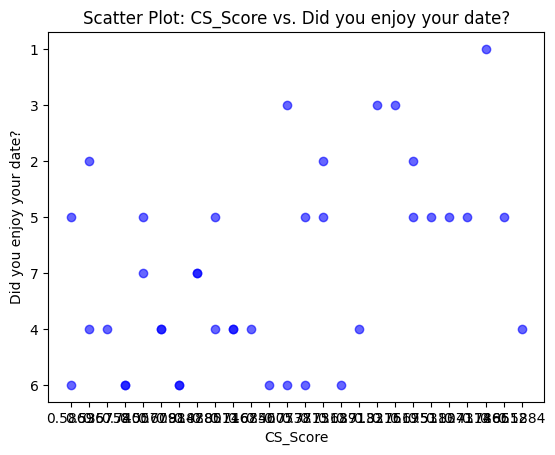

In [300]:
# Make a copy and include both needed columns
df2 = df[['CS_Score', 'Did you enjoy your date?']].dropna()

# Now both X and y can be taken from df2 safely
Xr = df2[['CS_Score']]
y = df2['Did you enjoy your date?'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

coefficients = pd.DataFrame(model.coef_, Xr.columns, columns=['Coefficient'])
print("\nLinear Regression Coefficients:")
print(coefficients)
intercept = model.intercept_
print(f"Intercept: {intercept}")


# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")


# Simple scatter plot of CS_Score vs. 'Did you enjoy your date?'
plt.scatter(df2['CS_Score'], df2['Did you enjoy your date?'], color='blue', alpha=0.6)

# Labels and title
plt.xlabel('CS_Score')
plt.ylabel('Did you enjoy your date?')
plt.title('Scatter Plot: CS_Score vs. Did you enjoy your date?')

# Show the plot
plt.show()

# 1) Multivariate Linear Regression



Using Multivariate Linear regression on a number of different post-survey questions.

Comparing all question to the post-survey question "Did you enjoy your date?'

This aims to find which questions led to a pleasant dinner, not fully considering romantic attraction.

An example graph for the most positively correlated question, the most negatively correlated question, and the least correlated question are provided.


Model Evaluation Metrics:
Mean Squared Error (MSE): 11.6584
R-squared Score: -2.4718
Top 5 coefficients:
      Coefficient
0               
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q55     0.151444
Q29     0.132595

Bottom 5 coefficients:
      Coefficient
0               
Q32    -0.128489
Q21    -0.140538
Q19    -0.167052
Q1     -0.189905
Q2     -0.327522

Closest to 0 coefficients:
      Coefficient
0               
Q37    -0.000881
Q6      0.001580
Q5     -0.002086
Q59    -0.004382
Q3     -0.006955


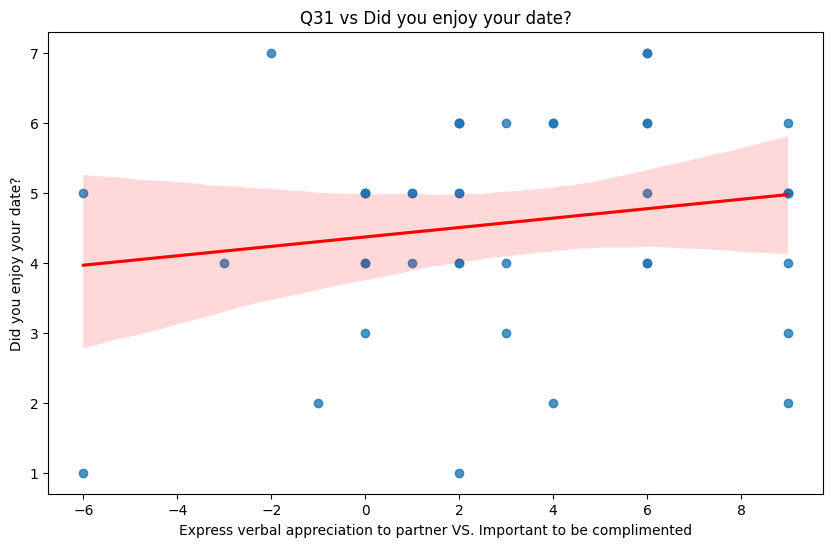

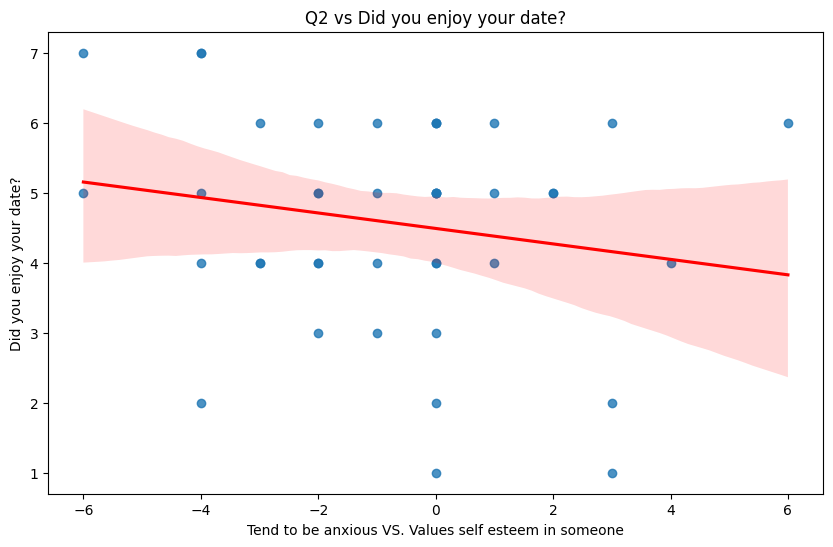

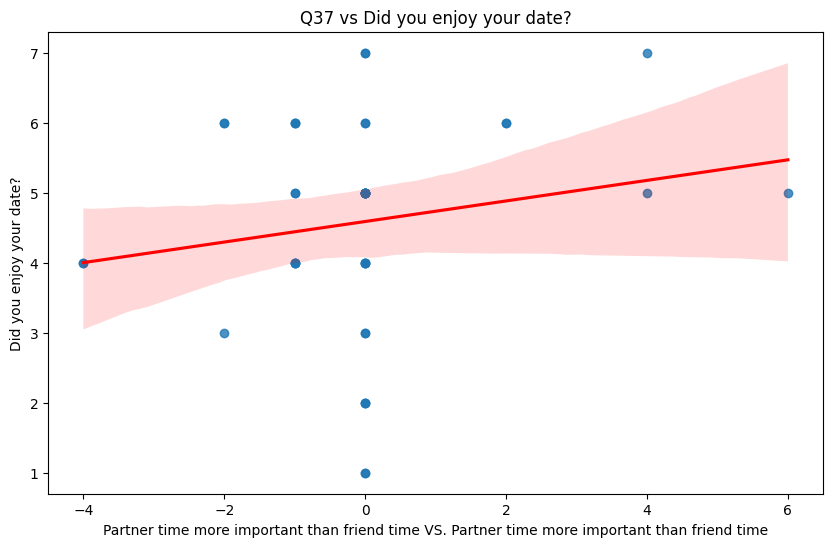

In [301]:
# Assign the partiular y variable as the 'Did you enjoy your date?' column.
y = df['Did you enjoy your date?'].astype(float)

# Split the data into training and testing sets, then fit it to the Linear Regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Print the coefficients in order of weight
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
# Print the 5 highest coefficients, the 5 lowest coefficients, and the 5 closest to 0
print("Top 5 coefficients:\n", coefficients.head(5))
print("\nBottom 5 coefficients:\n", coefficients.tail(5))
print("\nClosest to 0 coefficients:\n", coefficients.iloc[(coefficients['Coefficient'] - 0).abs().argsort()[:5]])

# Plot a graph of Q31 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q31'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q31'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q31 vs Did you enjoy your date?')
#plt.savefig('Q31_vs_y.png')    # Only needed once
plt.show()

# Plot a graph of Q2 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q2'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q2'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q2 vs Did you enjoy your date?')
#plt.savefig('Q2_vs_y.png')   # Only needed once
plt.show()

# Plot a graph of Q37 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q37'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q37'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q37 vs Did you enjoy your date?')
#plt.savefig('Q37_vs_y.png')    # Only needed once
plt.show()

Notably with Q37, multicolinearity prevented the variable from having much weight. Visibily in the graph, we can see that most reponses landed around the same line where x=0, so it makes sense that it doesn't contribute much to the final multivariable model. 

To fix this problem in comparisons, I wanted to analyze this problem and the following ones with forward stepwise selection. This helps eliminates less helpful variables strategically.

# 2) Linear Regression With Ridge

Also including up to 5 variable selection.
Test sample size is 9

In [302]:
model = Ridge(alpha = .1)

# Sequential Feature Selector
sfs = SFS(model,
          k_features=(1,5),       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,
          floating=True,
          scoring='neg_mean_squared_error',      # neg_mean_squared_error is used for compatibility with LOOCV
          cv=LeaveOneOut())        # LOOCV cv

# Returns the best model and prints info along the way
def runSelection(dataModel, X, y):
    # Standardize X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create DataFrame with original column names (optional, for readability)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

    selection = dataModel.fit(X_train, y_train)

    # Get selected features
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = [X.columns[i] for i in selected_indices]

    # Fit final model on selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Test
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Model name:", type(model).__name__)
    print(f"Number of features selected: {len(selected_features)}")
    print(f"{selection.k_feature_names_}\n")

   # Show coefficients (sorted by absolute value)
    print("Coefficients (sorted by magnitude):")
    coef_pairs = list(zip(selected_features, model.coef_))
    coef_sorted = sorted(coef_pairs, key=lambda x: abs(x[1]), reverse=True)

    for feature, coef in coef_sorted:
        question_name = qNames.get(feature, feature)  # Get the question name, fallback to feature if not found
        print(f"{feature}  {coef:.4f}:  {question_name}")

    print(f"Training -MSE: {selection.k_score_:.3f}\n")   # -MSE score

    n = X_test.shape[0]  # number of test samples
    print(f"number of test samples {n} / {X.shape[0]}")
    p = p = len(selected_features)  # Only count the features actually in the model
    print(f"number of features selected {p} / {X.shape[1]}")
    r2 = r2_score(y_test, y_pred)
    print(f"r2 score {r2}")
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print("Adjusted R-squared Score:", adjusted_r2)
    return selection

<span style="color:Orange">'Did you enjoy your date?'</span>

In [303]:
# Sets X to every feature excluding 'type' (because that is our y) and 'quality' (because the is another variable to predict)
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you enjoy your date?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: Ridge
Number of features selected: 5
('Q4', 'Q8', 'Q21', 'Q38', 'Q53')

Coefficients (sorted by magnitude):
Q4  -0.7360:  Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts
Q21  -0.5573:  Adjusts qick to last minute changes VS. Adjusts qick to last minute changes
Q38  0.4759:  Slapstick [Humor]
Q53  -0.3959:  Brain Rot [Humor]
Q8  0.3942:  Having fun more important than winning VS. Having fun more important than winning
Training -MSE: -1.049

number of test samples 9 / 42
number of features selected 5 / 60
r2 score -0.06683367838930909
Mean Squared Error: 3.081963959791337
R-squared Score: -0.06683367838930909
Adjusted R-squared Score: -1.8448898090381576


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(20,)","[-1.0911866622277144, -1.0467440359829436, -1....",-1.595291,"(Q21,)",0.729916,2.02949,0.358766
2,"(3, 20)","[-0.16421284275851605, -1.6655187097111497, -0...",-1.332862,"(Q4, Q21)",0.534899,1.487257,0.262912
3,"(3, 7, 20)","[-0.0501867930040475, -1.1361635620788153, -0....",-1.197953,"(Q4, Q8, Q21)",0.80102,2.22719,0.393715
4,"(3, 7, 20, 37)","[-0.4727815157726159, -0.9960716877005513, -0....",-1.138129,"(Q4, Q8, Q21, Q38)",0.683323,1.899941,0.335865
5,"(3, 7, 20, 37, 52)","[-0.7311525461861855, -0.6540235255714305, -0....",-1.049117,"(Q4, Q8, Q21, Q38, Q53)",0.57973,1.611906,0.284947


<span style="color:Orange">'Did your personalities match?'</span>

In [114]:
# Sets X to every feature excluding 'type' (because that is our y) and 'quality' (because the is another variable to predict)
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did your personalities match?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: Ridge
Number of features selected: 5
('Q10', 'Q24', 'Q33', 'Q50', 'Q52')

Coefficients (sorted by magnitude):
Q10  0.9643:  Easy to say sorry VS. Easy to say sorry
Q52  -0.6654:  *nuzzles you* [Humor]
Q24  -0.6095:  Worry about the future VS. Worry about the future
Q50  0.5640:  Witty Banter [Humor]
Q33  0.4030:  Tend to be very affectionate VS. Tend to be very affectionate
Training -MSE: -1.084

number of test samples 9 / 42
number of features selected 5 / 60
r2 score -1.262828855371724
Mean Squared Error: 4.413913075910276
R-squared Score: -1.262828855371724
Adjusted R-squared Score: -5.034210280991264


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[-0.519252731011991, -0.519252731011991, -5.77...",-1.869009,"(Q10,)",0.736563,2.04797,0.362033
2,"(9, 23)","[-1.0651746755972669, -1.0651746755972669, -4....",-1.435616,"(Q10, Q24)",0.687433,1.911368,0.337885
3,"(9, 23, 49)","[-0.35170991444483474, -0.17836501034393015, -...",-1.372041,"(Q10, Q24, Q50)",0.682408,1.897396,0.335415
4,"(9, 23, 49, 51)","[-0.11295505948868216, -0.0032852200730099064,...",-1.176799,"(Q10, Q24, Q50, Q52)",0.795248,2.211143,0.390879
5,"(9, 23, 32, 49, 51)","[-0.24171015330426385, -0.059581292867583235, ...",-1.08367,"(Q10, Q24, Q33, Q50, Q52)",0.618876,1.720749,0.304188


<span style="color:Orange">'Was there a romantic tension?'</span>

In [116]:
# Sets X to every feature excluding 'type' (because that is our y) and 'quality' (because the is another variable to predict)
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Was there a romantic tension?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: Ridge
Number of features selected: 5
('Q12', 'Q18', 'Q20', 'Q50', 'Q57')

Coefficients (sorted by magnitude):
Q20  -1.0514:  Enjoys a structured schedule VS. Enjoys a structured schedule
Q57  0.8935:  Dad Jokes [Humor]
Q18  0.7572:  Love to be in nature VS. Love to be in nature
Q12  -0.6741:  Is center of attention VS. Likes quieter personality
Q50  -0.4988:  Witty Banter [Humor]
Training -MSE: -0.804

number of test samples 9 / 42
number of features selected 5 / 60
r2 score -1.5108582426127626
Mean Squared Error: 3.595796989420746
R-squared Score: -1.5108582426127626
Adjusted R-squared Score: -5.6956219803007


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(19,)","[-2.889347882401066, -1.94614198800442, -0.132...",-1.698634,"(Q20,)",0.754753,2.098548,0.370974
2,"(11, 19)","[-0.9959737129942552, -0.1383843853167028, -0....",-1.433326,"(Q12, Q20)",0.658725,1.831549,0.323775
3,"(11, 19, 56)","[-1.8870943630010608, -0.05140603572292587, -0...",-1.158716,"(Q12, Q20, Q57)",0.570184,1.585364,0.280255
4,"(11, 17, 19, 56)","[-6.110416481224726, -1.1776575397378364, -0.0...",-0.964943,"(Q12, Q18, Q20, Q57)",0.449046,1.248546,0.220714
5,"(11, 17, 19, 49, 56)","[-3.9785346693145835, -0.4332300816318941, -0....",-0.804056,"(Q12, Q18, Q20, Q50, Q57)",0.338744,0.94186,0.166499


<span style="color:Orange">'Did you find them physically attractive?'</span>

In [118]:
# Sets X to every feature excluding 'type' (because that is our y) and 'quality' (because the is another variable to predict)
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you find them physically attractive?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: Ridge
Number of features selected: 5
('Q13', 'Q18', 'Q33', 'Q39', 'Q41')

Coefficients (sorted by magnitude):
Q13  -0.7986:  Burdened by initiating convrersation VS. Tends to initiate
Q33  0.5935:  Tend to be very affectionate VS. Tend to be very affectionate
Q41  0.4675:  Self-Deprecating [Humor]
Q18  0.4603:  Love to be in nature VS. Love to be in nature
Q39  0.4228:  Sarcasm [Humor]
Training -MSE: -2.483

number of test samples 9 / 42
number of features selected 5 / 60
r2 score -0.1845136975705728
Mean Squared Error: 5.6447195958301375
R-squared Score: -0.1845136975705728
Adjusted R-squared Score: -2.1587031935215273


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[-0.13348519503015585, -6.411773049630193, -5....",-2.90434,"(Q13,)",1.231331,3.423645,0.605221
2,"(12, 32)","[-0.0023452515037342514, -6.6906712064811495, ...",-2.695033,"(Q13, Q33)",1.13532,3.156694,0.55803
3,"(12, 17, 32)","[-0.15940985067385266, -3.5217000196321115, -6...",-2.575406,"(Q13, Q18, Q33)",1.082513,3.009866,0.532074
4,"(12, 17, 32, 40)","[-1.6698766063153696, -2.2054462233292393, -8....",-2.566082,"(Q13, Q18, Q33, Q41)",1.111869,3.091487,0.546503
5,"(12, 17, 32, 38, 40)","[-2.3240252329151483, -1.1172516684863392, -7....",-2.482908,"(Q13, Q18, Q33, Q39, Q41)",1.05778,2.941097,0.519917


# 3) Linear Discriminant Analysis

In [163]:
model = LDA()

# Sequential Feature Selector
sfs = SFS(model,                    # There is another option called "verbose=(0, 1, or 2)" that you can use to list info about each model as it runs. auto=0
          k_features=(1,5),       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,             # Forward selection
          floating=True,           # Previous features (for k-1) not required in the next iteration (for =True)
          scoring='accuracy',      # neg_mean_squared_error is a good choice and is interpretable with
          cv=LeaveOneOut())        # LOOCV

# Returns the best model
def runSelection(dataModel, X, y):
    # Standardize X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create DataFrame with original column names (optional, for readability)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

    selection = dataModel.fit(X_train, y_train)

    # Get selected features
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = [X.columns[i] for i in selected_indices]

    # Fit final model on selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Test
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Model name:", type(model).__name__)
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Precision: {precision:.3f}")
    print(f"Test Recall: {recall:.3f}")
    print(f"Test F1 Score: {f1:.3f}")

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return selection

<span style="color:Orange">'Did you want a second date?'</span>

In [164]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you want a second date?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: LinearDiscriminantAnalysis
Test Accuracy: 0.444
Test Precision: 0.483
Test Recall: 0.444
Test F1 Score: 0.459
Confusion Matrix:
 [[3 3]
 [2 1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.25      0.33      0.29         3

    accuracy                           0.44         9
   macro avg       0.42      0.42      0.42         9
weighted avg       0.48      0.44      0.46         9


Selected feature coefficients:
Q40     0.182   Dark Humor [Humor]
Q34     0.132   Importance on small physical gestures VS. Importance on small physical gestures
Q14    -0.095   Prefers to be by themselves VS. Prefers to be by themselves
Q21    -0.141   Adjusts qick to last minute changes VS. Adjusts qick to last minute changes


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(39,)","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0.666667,"(Q40,)",0.169543,0.471405,0.083333
2,"(20, 39)","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.727273,"(Q21, Q40)",0.160177,0.445362,0.07873
3,"(7, 20, 39)","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.727273,"(Q8, Q21, Q40)",0.160177,0.445362,0.07873
4,"(13, 20, 33, 39)","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.787879,"(Q14, Q21, Q34, Q40)",0.147031,0.40881,0.072268
5,"(0, 13, 20, 33, 39)","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.787879,"(Q1, Q14, Q21, Q34, Q40)",0.147031,0.40881,0.072268


<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

In [165]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you have a second date / is one lined up?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[


Model name: LinearDiscriminantAnalysis
Test Accuracy: 0.889
Test Precision: 0.790
Test Recall: 0.889
Test F1 Score: 0.837
Confusion Matrix:
 [[8 0]
 [1 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


Selected feature coefficients:
Q1     -0.190   Cries often VS. Uncofmortable consoling the unwell


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1,)",0.128954,0.35855,0.063383
2,"(0, 1)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2)",0.128954,0.35855,0.063383
3,"(0, 1, 4)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q5)",0.128954,0.35855,0.063383
4,"(0, 1, 4, 5)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q5, Q6)",0.128954,0.35855,0.063383
5,"(0, 1, 4, 5, 7)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q5, Q6, Q8)",0.128954,0.35855,0.063383


<span style="color:Orange">'Do you expect to be friends with this person?'</span>

In [166]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Do you expect to be friends with this person?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/

Model name: LinearDiscriminantAnalysis
Test Accuracy: 0.667
Test Precision: 0.833
Test Recall: 0.667
Test F1 Score: 0.667
Confusion Matrix:
 [[3 3]
 [0 3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.50      1.00      0.67         3

    accuracy                           0.67         9
   macro avg       0.75      0.75      0.67         9
weighted avg       0.83      0.67      0.67         9


Selected feature coefficients:
Q41     0.026   Self-Deprecating [Humor]


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(40,)","[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q41,)",0.165286,0.459568,0.081241
2,"(18, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q19, Q41)",0.165286,0.459568,0.081241
3,"(3, 18, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q4, Q19, Q41)",0.165286,0.459568,0.081241
4,"(3, 9, 18, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q4, Q10, Q19, Q41)",0.165286,0.459568,0.081241
5,"(3, 9, 18, 34, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q4, Q10, Q19, Q35, Q41)",0.165286,0.459568,0.081241


# 4) Logistic Regression

In [304]:
model = LogisticRegression(max_iter=1000)

# Sequential Feature Selector
sfs = SFS(model,                    # There is another option called "verbose=(0, 1, or 2)" that you can use to list info about each model as it runs. auto=0
          k_features=(1,5),       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,             # Forward selection
          floating=True,           # Previous features (for k-1) not required in the next iteration (for =True)
          scoring='accuracy',      # neg_mean_squared_error is a good choice and is interpretable with
          cv=LeaveOneOut())        # 5 fold cross validation

# Returns the best model
def runSelection(dataModel, X, y):
    # Standardize X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create DataFrame with original column names (optional, for readability)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

    selection = dataModel.fit(X_train, y_train)

    # Get selected features
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = [X.columns[i] for i in selected_indices]

    # Fit final model on selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Test
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Model name:", type(model).__name__)
    print(f"Number of features selected: {len(selected_features)}")
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Precision: {precision:.3f}")
    print(f"Test Recall: {recall:.3f}")
    print(f"Test F1 Score: {f1:.3f}")

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return selection

<span style="color:Orange">'Did you want a second date?'</span>

In [305]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you want a second date?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: LogisticRegression
Number of features selected: 3
Test Accuracy: 0.556
Test Precision: 0.633
Test Recall: 0.556
Test F1 Score: 0.567
Confusion Matrix:
 [[3 3]
 [1 2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.40      0.67      0.50         3

    accuracy                           0.56         9
   macro avg       0.57      0.58      0.55         9
weighted avg       0.63      0.56      0.57         9


Selected feature coefficients:
Q17     0.076   Seek out new experiences VS. Seek out new experiences
Q20    -0.065   Enjoys a structured schedule VS. Enjoys a structured schedule
Q11    -0.070   Talk to strangers VS. Likes outgoing people


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(10,)","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.636364,"(Q11,)",0.17301,0.481046,0.085038
2,"(10, 19)","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.666667,"(Q11, Q20)",0.169543,0.471405,0.083333
3,"(10, 16, 19)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.757576,"(Q11, Q17, Q20)",0.15413,0.42855,0.075758
4,"(2, 10, 16, 19)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.757576,"(Q3, Q11, Q17, Q20)",0.15413,0.42855,0.075758
5,"(2, 6, 10, 16, 19)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.757576,"(Q3, Q7, Q11, Q17, Q20)",0.15413,0.42855,0.075758


<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

In [306]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Did you have a second date / is one lined up?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: LogisticRegression
Number of features selected: 1
Test Accuracy: 0.889
Test Precision: 0.790
Test Recall: 0.889
Test F1 Score: 0.837
Confusion Matrix:
 [[8 0]
 [1 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


Selected feature coefficients:
Q1     -0.190   Cries often VS. Uncofmortable consoling the unwell


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1,)",0.128954,0.35855,0.063383
2,"(0, 1)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2)",0.128954,0.35855,0.063383
3,"(0, 1, 2)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q3)",0.128954,0.35855,0.063383
4,"(0, 1, 2, 3)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q3, Q4)",0.128954,0.35855,0.063383
5,"(0, 1, 2, 3, 5)","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.848485,"(Q1, Q2, Q3, Q4, Q6)",0.128954,0.35855,0.063383


<span style="color:Orange">'Do you expect to be friends with this person?'</span>

In [307]:
X = df[qVec]  # axis=1 tells python it is a column and not a row
y = df['Do you expect to be friends with this person?']

selection = runSelection(sfs, X, y)

# Tells relevant data from sfs
featureSelection(selection)
pd.DataFrame.from_dict(selection.get_metric_dict()).T

Model name: LogisticRegression
Number of features selected: 4
Test Accuracy: 0.556
Test Precision: 0.633
Test Recall: 0.556
Test F1 Score: 0.567
Confusion Matrix:
 [[3 3]
 [1 2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.40      0.67      0.50         3

    accuracy                           0.56         9
   macro avg       0.57      0.58      0.55         9
weighted avg       0.63      0.56      0.57         9


Selected feature coefficients:
Q26     0.053   Reserved with emotions VS. Reserved with emotions
Q38     0.050   Slapstick [Humor]
Q41     0.026   Self-Deprecating [Humor]
Q44    -0.086   Deadpan [Humor]


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(40,)","[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.69697,"(Q41,)",0.165286,0.459568,0.081241
2,"(37, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0.727273,"(Q38, Q41)",0.160177,0.445362,0.07873
3,"(25, 37, 40)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.727273,"(Q26, Q38, Q41)",0.160177,0.445362,0.07873
4,"(25, 37, 40, 43)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0.757576,"(Q26, Q38, Q41, Q44)",0.15413,0.42855,0.075758
5,"(9, 25, 37, 40, 43)","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0.727273,"(Q10, Q26, Q38, Q41, Q44)",0.160177,0.445362,0.07873


# 5) K Means Classification

<span style="color:Orange">'Did you want a second date?'</span>

In [199]:
data = df.copy()

# Define features (X) and target (y)
X = data[qVec]
y = data['Did you want a second date?']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

# Apply PCA
pca = PCA(n_components=2)  # reduce to fewer components (adjust if needed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

# Predict clusters for train and test data
train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Map clusters to labels based on majority class in training set
label_map = {}
for cluster_id in np.unique(train_clusters):
    mask = train_clusters == cluster_id
    majority_label = mode(y_train[mask], keepdims=False).mode
    label_map[cluster_id] = majority_label

# Apply mapping
mapped_preds = np.vectorize(label_map.get)(test_clusters)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, mapped_preds))
print("\nClassification Report:\n", classification_report(y_test, mapped_preds))
print(f"Adjusted Rand Index (ARI): {adjusted_rand_score(y_test, mapped_preds):.3f}")

# Get the loadings (influence of each feature on each PC)
loadings = pca.components_.T  # shape: (original_features, n_components)

# Create a DataFrame for easier viewing
loading_df = pd.DataFrame(loadings, index=qVec, columns=[f"PC{i+1}" for i in range(pca.n_components)])

# Calculate the total influence of each question (feature)
# You can use absolute values to capture overall contribution
loading_df['total_magnitude'] = loading_df.abs().sum(axis=1)

# Sort by total magnitude of contribution
top_features = loading_df.sort_values('total_magnitude', ascending=False)

print("Top contributing questions to PCA components (influence on clustering):")
print(top_features.head(10))


Confusion Matrix:
 [[6 0]
 [3 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9

Adjusted Rand Index (ARI): 0.000
Top contributing questions to PCA components (influence on clustering):
          PC1       PC2  total_magnitude
Q15 -0.094685  0.332268         0.426953
Q20  0.219442 -0.203825         0.423267
Q19 -0.140535  0.247405         0.387940
Q8  -0.086997  0.272818         0.359815
Q26 -0.163925  0.186712         0.350637
Q52  0.234999  0.107063         0.342062
Q53 -0.180826 -0.160475         0.341301
Q32  0.269945  0.070152         0.340096
Q51  0.112295  0.219862         0.332157
Q57  0.256399 -0.068241         0.324640


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

I tried using PCA to shrink the data but it did not seem to work.

<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

In [310]:
data = df.copy()

# Define features (X) and target (y)
X = data[qVec]
y = data['Did you have a second date / is one lined up?']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

# Apply PCA
pca = PCA(n_components=2)  # reduce to fewer components (adjust if needed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

# Predict clusters for train and test data
train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Map clusters to labels based on majority class in training set
label_map = {}
for cluster_id in np.unique(train_clusters):
    mask = train_clusters == cluster_id
    majority_label = mode(y_train[mask], keepdims=False).mode
    label_map[cluster_id] = majority_label

# Apply mapping
mapped_preds = np.vectorize(label_map.get)(test_clusters)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, mapped_preds))
print("\nClassification Report:\n", classification_report(y_test, mapped_preds))
print(f"Adjusted Rand Index (ARI): {adjusted_rand_score(y_test, mapped_preds):.3f}")

# Get the loadings (influence of each feature on each PC)
loadings = pca.components_.T  # shape: (original_features, n_components)

# Create a DataFrame for easier viewing
loading_df = pd.DataFrame(loadings, index=qVec, columns=[f"PC{i+1}" for i in range(pca.n_components)])

# Calculate the total influence of each question (feature)
# You can use absolute values to capture overall contribution
loading_df['total_magnitude'] = loading_df.abs().sum(axis=1)

# Sort by total magnitude of contribution
top_features = loading_df.sort_values('total_magnitude', ascending=False)

print("Top contributing questions to PCA components (influence on clustering):")
print(top_features.head(10))


Confusion Matrix:
 [[8 0]
 [1 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

Adjusted Rand Index (ARI): 0.000
Top contributing questions to PCA components (influence on clustering):
          PC1       PC2  total_magnitude
Q15 -0.094685  0.332268         0.426953
Q20  0.219442 -0.203825         0.423267
Q19 -0.140535  0.247405         0.387940
Q8  -0.086997  0.272818         0.359815
Q26 -0.163925  0.186712         0.350637
Q52  0.234999  0.107063         0.342062
Q53 -0.180826 -0.160475         0.341301
Q32  0.269945  0.070152         0.340096
Q51  0.112295  0.219862         0.332157
Q57  0.256399 -0.068241         0.324640


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

<span style="color:Orange">'Do you expect to be friends with this person?'</span>

In [198]:
data = df.copy()

# Define features (X) and target (y)
X = data[qVec]
y = data['Do you expect to be friends with this person?']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=52)

# Apply PCA
pca = PCA(n_components=2)  # reduce to fewer components (adjust if needed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

# Predict clusters for train and test data
train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Map clusters to labels based on majority class in training set
label_map = {}
for cluster_id in np.unique(train_clusters):
    mask = train_clusters == cluster_id
    majority_label = mode(y_train[mask], keepdims=False).mode
    label_map[cluster_id] = majority_label

# Apply mapping
mapped_preds = np.vectorize(label_map.get)(test_clusters)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, mapped_preds))
print("\nClassification Report:\n", classification_report(y_test, mapped_preds))
print(f"Adjusted Rand Index (ARI): {adjusted_rand_score(y_test, mapped_preds):.3f}")

# Get the loadings (influence of each feature on each PC)
loadings = pca.components_.T  # shape: (original_features, n_components)

# Create a DataFrame for easier viewing
loading_df = pd.DataFrame(loadings, index=qVec, columns=[f"PC{i+1}" for i in range(pca.n_components)])

# Calculate the total influence of each question (feature)
# You can use absolute values to capture overall contribution
loading_df['total_magnitude'] = loading_df.abs().sum(axis=1)

# Sort by total magnitude of contribution
top_features = loading_df.sort_values('total_magnitude', ascending=False)

print("Top contributing questions to PCA components (influence on clustering):")
print(top_features.head(10))



Confusion Matrix:
 [[1 5]
 [0 3]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.38      1.00      0.55         3

    accuracy                           0.44         9
   macro avg       0.69      0.58      0.42         9
weighted avg       0.79      0.44      0.37         9

Adjusted Rand Index (ARI): -0.111
Top contributing questions to PCA components (influence on clustering):
          PC1       PC2  total_magnitude
Q15 -0.094685  0.332268         0.426953
Q20  0.219442 -0.203825         0.423267
Q19 -0.140535  0.247405         0.387940
Q8  -0.086997  0.272818         0.359815
Q26 -0.163925  0.186712         0.350637
Q52  0.234999  0.107063         0.342062
Q53 -0.180826 -0.160475         0.341301
Q32  0.269945  0.070152         0.340096
Q51  0.112295  0.219862         0.332157
Q57  0.256399 -0.068241         0.324640


# 6) Random Forest (Classification)

<span style="color:Orange">'Did you want a second date?'</span>

Accuracy: 0.2222222222222222
Confusion Matrix:
 [[2 3]
 [4 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.00      0.00      0.00         4

    accuracy                           0.22         9
   macro avg       0.17      0.20      0.18         9
weighted avg       0.19      0.22      0.20         9



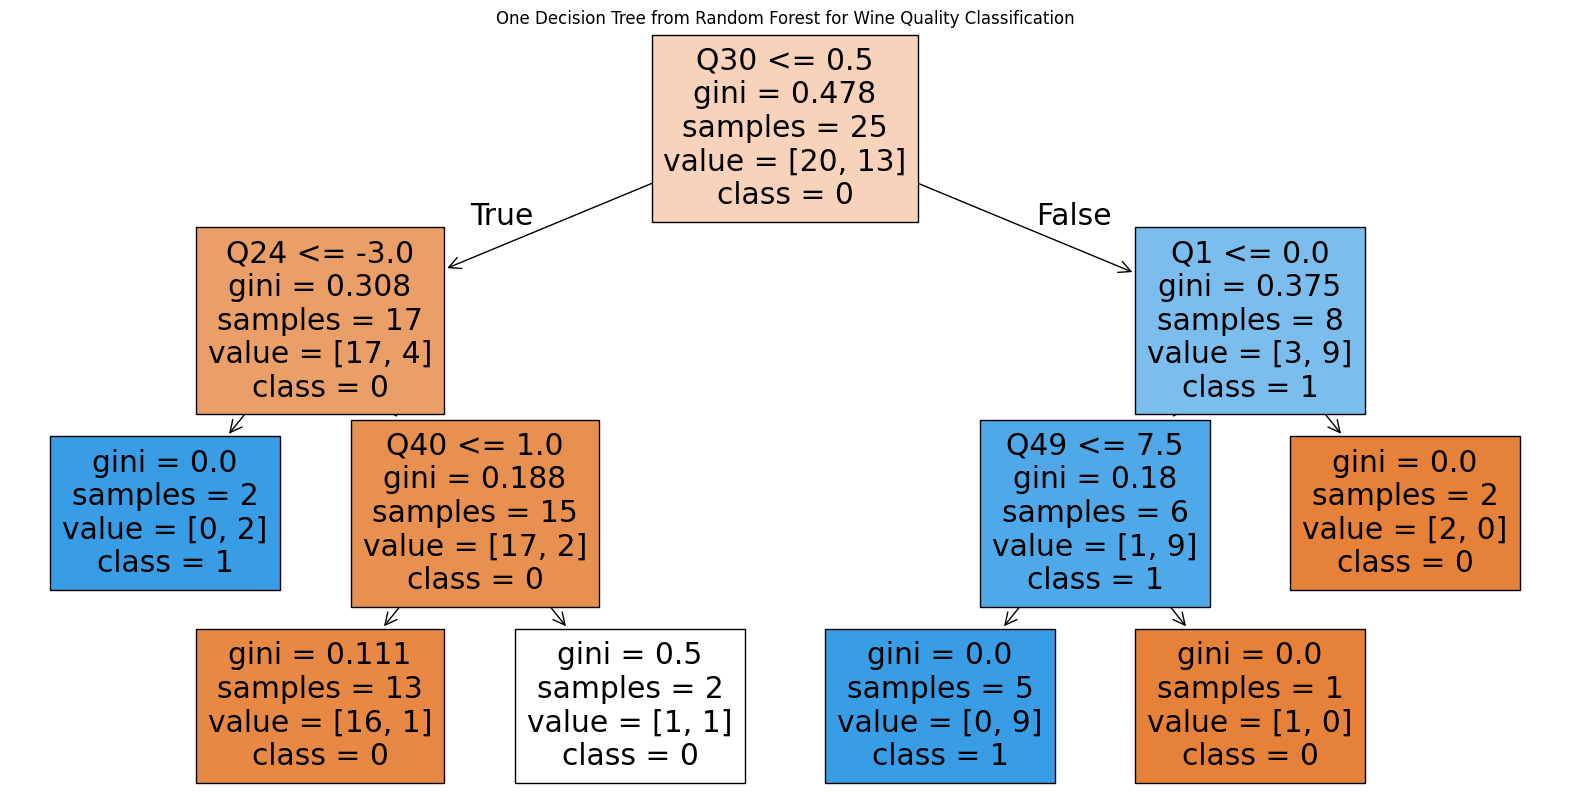

In [208]:
# X = everything but // predicting quality (our regression output)
X = df[qVec]
y = data['Did you want a second date?']  # This is the target variable

# Scale the X data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree Classifier
model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=42)    # max_depth = 2 for interpretability
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show Feature Importances
importances = model.feature_importances_
feature_names = X.columns

# Sort importances and feature names together
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Print Top Features
print("Top Feature Importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

'''
The importance score for each feature is the total reduction in impurity (e.g., Gini) it brings across all trees and all nodes where it's used.
These reductions are then:
Averaged across all trees in the forest
Normalized so the total importances add up to 1
'''

# Visualize the First Tree in the Forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],  # First tree from the forest
          feature_names=X.columns,
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True)
plt.title("One Decision Tree from Random Forest for Wine Quality Classification")
plt.show()


<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

Accuracy: 1.0
Confusion Matrix:
 [[8 0]
 [0 1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



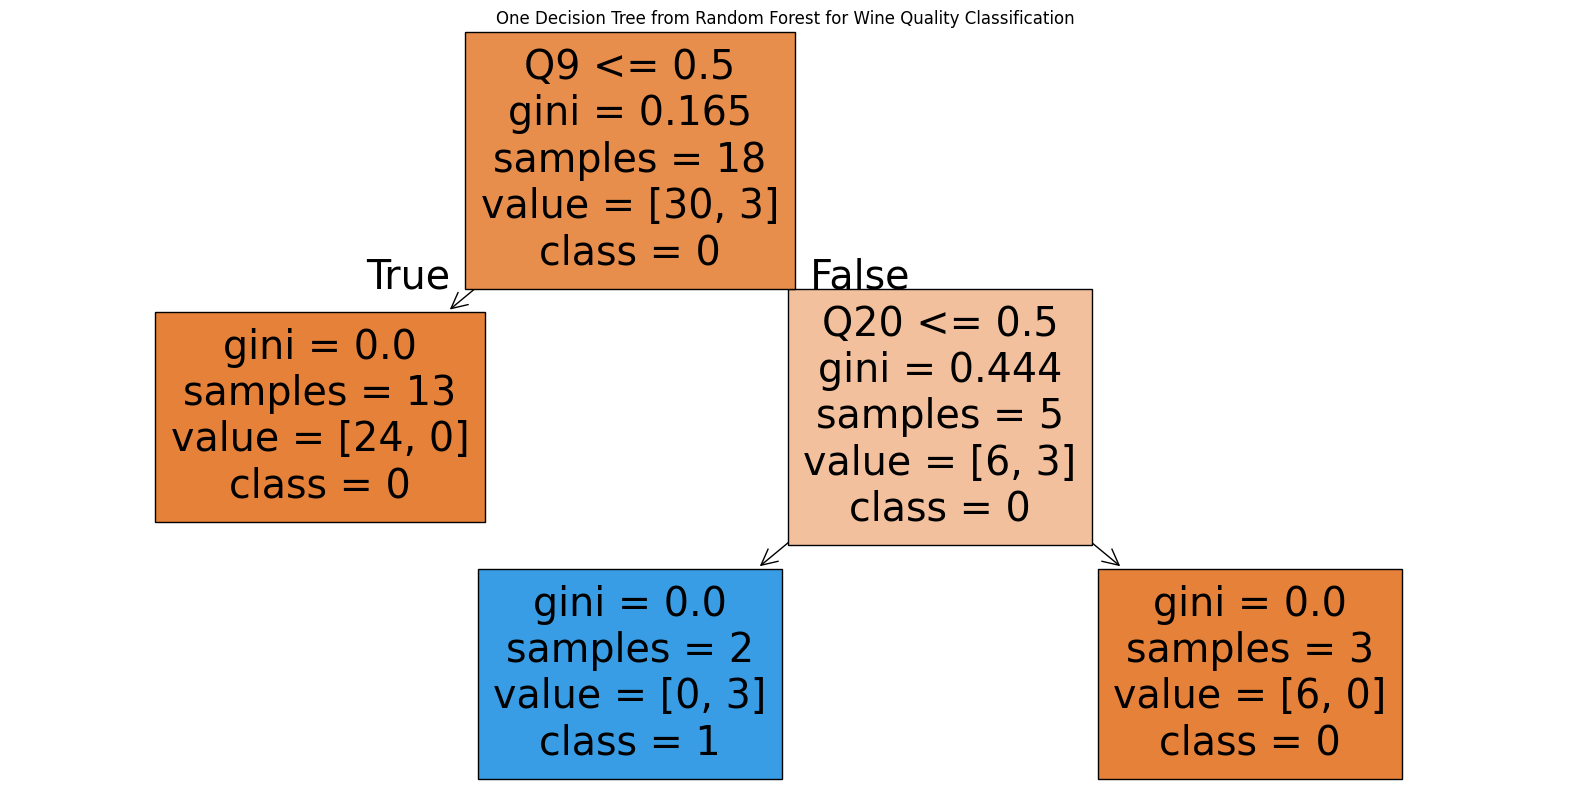

In [214]:
# X = everything but // predicting quality (our regression output)
X = df[qVec]
y = data['Did you have a second date / is one lined up?']  # This is the target variable

# Scale the X data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree Classifier
model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=47)    # max_depth = 3 for interpretability
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show Feature Importances
importances = model.feature_importances_
feature_names = X.columns

# Sort importances and feature names together
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Print Top Features
print("Top Feature Importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

# Visualize the First Tree in the Forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],  # First tree from the forest
          feature_names=X.columns,
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True)
plt.title("One Decision Tree from Random Forest for Wine Quality Classification")
plt.show()


<span style="color:Orange">'Do you expect to be friends with this person?'</span>

Accuracy: 0.6666666666666666
Confusion Matrix:
 [[4 0]
 [3 2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.40      0.57         5

    accuracy                           0.67         9
   macro avg       0.79      0.70      0.65         9
weighted avg       0.81      0.67      0.64         9

Top Feature Importances:
Q7: 0.0510
Q21: 0.0378
Q9: 0.0378
Q6: 0.0318
Q57: 0.0313
Q41: 0.0275
Q45: 0.0266
Q15: 0.0254
Q3: 0.0247
Q2: 0.0240
Q58: 0.0221
Q1: 0.0219
Q26: 0.0216
Q49: 0.0213
Q53: 0.0206
Q38: 0.0204
Q16: 0.0204
Q56: 0.0200
Q31: 0.0192
Q42: 0.0187
Q12: 0.0183
Q60: 0.0175
Q14: 0.0169
Q55: 0.0168
Q10: 0.0166
Q33: 0.0162
Q30: 0.0161
Q23: 0.0161
Q47: 0.0159
Q37: 0.0154
Q22: 0.0150
Q25: 0.0148
Q20: 0.0145
Q29: 0.0140
Q32: 0.0136
Q13: 0.0134
Q17: 0.0129
Q11: 0.0127
Q19: 0.0124
Q36: 0.0116
Q44: 0.0112
Q34: 0.0111
Q52: 0.0109
Q4: 0.0107
Q35: 0.0104
Q46: 0.0102
Q39: 0.0100
Q28

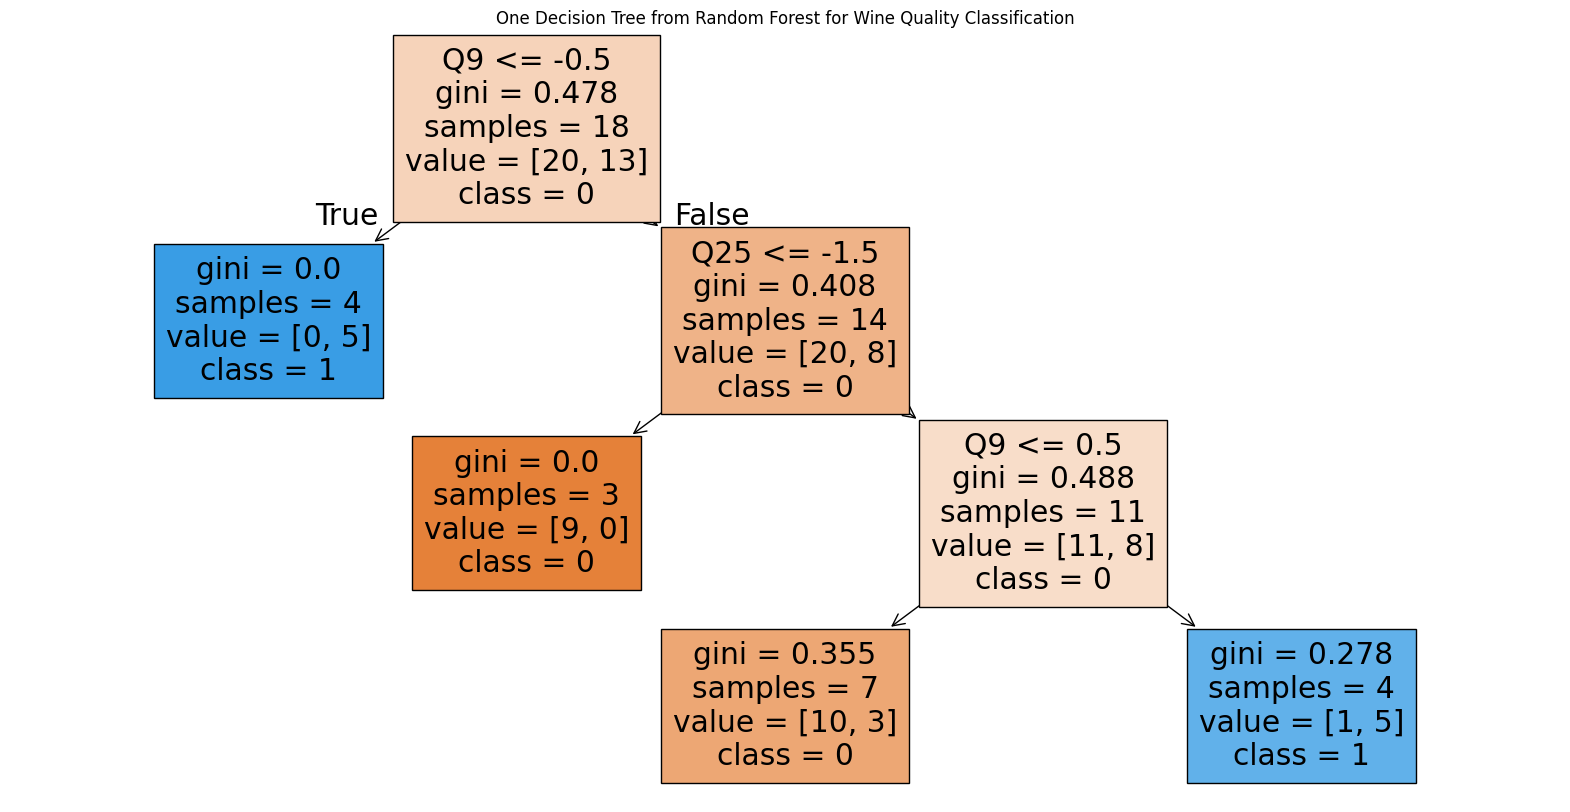

In [216]:
# X = everything but // predicting quality (our regression output)
X = df[qVec]
y = data['Do you expect to be friends with this person?']  # This is the target variable

# Scale the X data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree Classifier
model = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=47)    # max_depth = 3 for interpretability
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show Feature Importances
importances = model.feature_importances_
feature_names = X.columns

# Sort importances and feature names together
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Print Top Features
print("Top Feature Importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

# Visualize the First Tree in the Forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],  # First tree from the forest
          feature_names=X.columns,
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True)
plt.title("One Decision Tree from Random Forest for Wine Quality Classification")
plt.show()


# 7) SVM (Regressor)


<span style="color:Orange">'Did you enjoy your date?'</span>

In [233]:
# Define features (X) and target (y)
X = data[qVec]
y = data['Did you want a second date?']    

# Scale the features (SVM performs better with scaled features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Support Vector Regression (SVR) model
svr_model = SVR(kernel='rbf', max_iter=1000)  # RBF kernel (you can try 'linear' or 'poly')
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

n = X_test.shape[0]  # number of test samples
p = X_test.shape[1]  # number of predictors/features
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Compute permutation importance
result = permutation_importance(svr_model, X_test, y_test, n_repeats=30, random_state=42)

# Display results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Mean Squared Error: 0.411220963866326
R-squared Score: -0.6654449036586203
   Feature  Importance
1       Q2    0.028154
22     Q23    0.012726
52     Q53    0.001895
5       Q6   -0.000214
10     Q11   -0.001958
11     Q12   -0.003174
59     Q60   -0.004252
15     Q16   -0.006844
34     Q35   -0.008146
3       Q4   -0.009188
0       Q1   -0.009190
24     Q25   -0.010771
16     Q17   -0.011341
19     Q20   -0.012152
9      Q10   -0.012446
26     Q27   -0.012912
40     Q41   -0.015369
54     Q55   -0.015759
30     Q31   -0.016081
27     Q28   -0.016152
50     Q51   -0.016288
33     Q34   -0.016563
35     Q36   -0.016692
56     Q57   -0.017589
47     Q48   -0.018242
29     Q30   -0.019708
55     Q56   -0.020496
18     Q19   -0.021168
28     Q29   -0.021727
13     Q14   -0.022699
41     Q42   -0.023535
37     Q38   -0.024036
17     Q18   -0.024042
44     Q45   -0.024314
39     Q40   -0.024386
6       Q7   -0.024569
7       Q8   -0.024887
20     Q21   -0.025638
25     Q26   -0.026999
53   

<span style="color:Orange">'Did your personalities match?'</span>

In [234]:
# Define features (X) and target (y)
X = data[qVec]
y = data['Did your personalities match?']    

# Scale the features (SVM performs better with scaled features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Support Vector Regression (SVR) model
svr_model = SVR(kernel='rbf', max_iter=1000)  # RBF kernel (you can try 'linear' or 'poly')
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

n = X_test.shape[0]  # number of test samples
p = X_test.shape[1]  # number of predictors/features
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Compute permutation importance
result = permutation_importance(svr_model, X_test, y_test, n_repeats=30, random_state=42)

# Display results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Mean Squared Error: 1.9786774530355358
R-squared Score: -0.6354374866926367
   Feature  Importance
7       Q8    0.028472
33     Q34    0.018152
10     Q11    0.002416
9      Q10    0.002259
1       Q2    0.002248
12     Q13    0.002201
5       Q6    0.001653
45     Q46    0.001500
19     Q20    0.001326
37     Q38   -0.001918
59     Q60   -0.003205
11     Q12   -0.004784
53     Q54   -0.005518
18     Q19   -0.007370
35     Q36   -0.008932
6       Q7   -0.010377
32     Q33   -0.010799
48     Q49   -0.011349
0       Q1   -0.011908
56     Q57   -0.012329
25     Q26   -0.012608
36     Q37   -0.016794
34     Q35   -0.017702
15     Q16   -0.017722
14     Q15   -0.017734
46     Q47   -0.017904
2       Q3   -0.018213
57     Q58   -0.018608
41     Q42   -0.018777
40     Q41   -0.019052
20     Q21   -0.019157
29     Q30   -0.019556
26     Q27   -0.020237
22     Q23   -0.021006
28     Q29   -0.022994
58     Q59   -0.022998
4       Q5   -0.023103
55     Q56   -0.023561
24     Q25   -0.024653
52  

<span style="color:Orange">'Was there a romantic tension?'</span>

In [235]:
# Define features (X) and target (y)
X = data[qVec]
y = data['Was there a romantic tension?']    

# Scale the features (SVM performs better with scaled features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Support Vector Regression (SVR) model
svr_model = SVR(kernel='rbf', max_iter=1000)  # RBF kernel (you can try 'linear' or 'poly')
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

n = X_test.shape[0]  # number of test samples
p = X_test.shape[1]  # number of predictors/features
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Compute permutation importance
result = permutation_importance(svr_model, X_test, y_test, n_repeats=30, random_state=42)

# Display results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Mean Squared Error: 3.1365644782584194
R-squared Score: -0.8147265909923711
   Feature  Importance
12     Q13    0.022688
55     Q56    0.015744
8       Q9    0.011432
11     Q12    0.010961
19     Q20    0.008957
0       Q1    0.008469
53     Q54    0.008373
10     Q11    0.006002
25     Q26    0.005221
57     Q58    0.004858
14     Q15    0.004612
30     Q31    0.003893
54     Q55    0.002527
46     Q47    0.001500
22     Q23    0.000990
33     Q34    0.000974
32     Q33    0.000907
21     Q22    0.000842
17     Q18    0.000640
18     Q19    0.000513
59     Q60   -0.000141
45     Q46   -0.000144
51     Q52   -0.000236
37     Q38   -0.000251
29     Q30   -0.000456
5       Q6   -0.000841
9      Q10   -0.001725
35     Q36   -0.004013
1       Q2   -0.004339
41     Q42   -0.005044
44     Q45   -0.005104
36     Q37   -0.006305
26     Q27   -0.006490
38     Q39   -0.006539
3       Q4   -0.006631
49     Q50   -0.007222
15     Q16   -0.008181
47     Q48   -0.009094
24     Q25   -0.009987
43  

<span style="color:Orange">'Did you find them physically attractive?'</span>

In [237]:
# Define features (X) and target (y)
X = data[qVec]
y = data['Did you find them physically attractive?']    

# Scale the features (SVM performs better with scaled features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Support Vector Regression (SVR) model
svr_model = SVR(kernel='rbf', max_iter=1000)  # RBF kernel (you can try 'linear' or 'poly')
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

n = X_test.shape[0]  # number of test samples
p = X_test.shape[1]  # number of predictors/features
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Compute permutation importance
result = permutation_importance(svr_model, X_test, y_test, n_repeats=30, random_state=42)

# Display results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Mean Squared Error: 6.051499525957187
R-squared Score: -0.400489890292949
   Feature  Importance
0       Q1    0.002780
10     Q11    0.002300
1       Q2    0.000143
53     Q54   -0.000602
59     Q60   -0.000861
55     Q56   -0.000999
5       Q6   -0.001426
11     Q12   -0.001446
12     Q13   -0.001805
19     Q20   -0.003527
9      Q10   -0.003946
18     Q19   -0.004338
34     Q35   -0.004537
25     Q26   -0.004712
22     Q23   -0.006523
35     Q36   -0.007178
2       Q3   -0.007538
47     Q48   -0.007615
32     Q33   -0.008207
30     Q31   -0.009180
50     Q51   -0.009341
7       Q8   -0.009450
14     Q15   -0.009466
26     Q27   -0.011430
33     Q34   -0.012501
41     Q42   -0.013009
52     Q53   -0.013192
6       Q7   -0.013347
51     Q52   -0.013480
54     Q55   -0.013498
8       Q9   -0.013658
3       Q4   -0.014313
46     Q47   -0.014340
48     Q49   -0.015602
38     Q39   -0.015740
28     Q29   -0.016224
40     Q41   -0.016251
37     Q38   -0.016672
39     Q40   -0.017328
29    